In [5]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch 

import pickle
from kg import KnowledgeGraph

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = os.environ.get('DATA_DIR', './Data')
output_dir = os.environ.get('OUTPUT_DIR', './Output')

In [7]:
## Add node indices
## nodes_df: Dataframe containing node information with columns: node_idx, node_id, node_type
## relations_df: Dataframe containing relation information with columns: source ID/type, target ID/type

def add_node_indices(nodes_df, relations_df):
    """
    Add node indices from nodes dataframe to relations dataframe based on ID and type matching.
    
    Args:
    	nodes_df (pd.DataFrame): Dataframe containing node information with columns: node_idx, node_id, node_type
    	relations_df (pd.DataFrame): Dataframe containing relation information with columns: x_id, x_type, y_id, y_type
   
    Returns:
    	pd.DataFrame: Filtered relations dataframe with added x_idx, y_idx, and included columns
    """
    # Create a copy of the relations dataframe to avoid modifying the original
    result_df = relations_df.copy()
    
    # Convert node_id to string type in nodes_df for consistent matching
    nodes_df = nodes_df.copy()
    nodes_df['node_id'] = nodes_df['node_id'].astype(str)
    
    # Convert x_id and y_id to string type in relations_df
    result_df['x_id'] = result_df['x_id'].astype(str)
    result_df['y_id'] = result_df['y_id'].astype(str)
    
    # Create a mapping dictionary from (node_id, node_type) to node_idx
    node_mapping = pd.Series(
        nodes_df.node_idx.values,
        index=pd.MultiIndex.from_arrays([nodes_df.node_id, nodes_df.node_type])
    ).to_dict()
    
    # Create a function to safely get mapping value
    def get_mapping(row, id_col, type_col):
        key = (row[id_col], row[type_col])
        return node_mapping.get(key)
    
    # Add x_idx column by mapping (x_id, x_type)
    result_df['x_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'x_id', 'x_type'), 
        axis=1
    )
    
    # Add y_idx column by mapping (y_id, y_type)
    result_df['y_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'y_id', 'y_type'), 
        axis=1
    )
    
    # Check if both indices are valid (not NaN) and add 'included' column
    result_df['included'] = result_df['x_idx'].notna() & result_df['y_idx'].notna()
    
    # Filter rows where both x_idx and y_idx are not NaN
    result_df = result_df[result_df['included']].copy()
    
    # Convert x_idx and y_idx to integers
    result_df['x_idx'] = result_df['x_idx'].astype(int)
    result_df['y_idx'] = result_df['y_idx'].astype(int)
    
    return result_df


data_dir = os.environ.get('DATA_DIR', './Data')
output_dir = os.environ.get('OUTPUT_DIR', './Output')

df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')
print("Loading HPO to index dictionary...")

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/hpo_to_idx_dict_8.9.21_kg.pkl', 'rb') as f:
    hpo_to_idx_dict = pickle.load(f)

print("Loading Genes to index dictionary...")
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/ensembl_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    genes = pickle.load(file)

with open(f'{data_dir}/preprocess/orphanet/orphanet_to_mondo_dict.pkl', 'rb') as file:
        orphanet_to_mondo_dict = pickle.load(file)

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/mondo_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    mondo_to_idx_dict = pickle.load(file)

# create_nodes_pkl(data_dir)
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl', 'rb') as file:
    nodes = pickle.load(file)

/tmp/ipykernel_13231/2845939711.py:66: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')


Loading HPO to index dictionary...
Loading Genes to index dictionary...


In [9]:
# The nodes_8.9.21_kg.pkl file contains node information with columns: node_idx, node_id, node_type
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl', 'rb') as file:
    nodes = pickle.load(file)

print("\nFirst 5 rows of the data:")
print(nodes.head(5),"\n")
print("there are:",nodes.shape[0],"of nodes \n")
print(nodes['node_type'].value_counts())


First 5 rows of the data:
   node_idx node_id     node_type        node_name node_source old_node_name
0         0    9796  gene/protein  ENSG00000168490        NCBI        PHYHIP
1         1    7918  gene/protein  ENSG00000204438        NCBI        GPANK1
2         2    8233  gene/protein  ENSG00000169249        NCBI         ZRSR2
3         3    4899  gene/protein  ENSG00000106459        NCBI          NRF1
4         4    5297  gene/protein  ENSG00000241973        NCBI         PI4KA 

there are: 105220 of nodes 

node_type
biological_process    28642
gene/protein          21610
disease               21233
effect/phenotype      15874
molecular_function    11169
cellular_component     4176
pathway                2516
Name: count, dtype: int64
total number of nodes: 105220


In [10]:
# the kg_giant_orphanet.csv file contains the relationships between nodes with columns
# this is the predefined relationships between nodes
df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')

print("\nFirst 5 rows of relationships:")
print(df.head(5), "\n")
print("there are:",df.shape[0],"of relationships \n")
print(df['relation'].value_counts())


/tmp/ipykernel_13231/3825346476.py:3: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')



First 5 rows of relationships:
          relation display_relation  x_id        x_type  x_name x_source  \
0  protein_protein              ppi  9796  gene/protein  PHYHIP     NCBI   
1  protein_protein              ppi  7918  gene/protein  GPANK1     NCBI   
2  protein_protein              ppi  8233  gene/protein   ZRSR2     NCBI   
3  protein_protein              ppi  4899  gene/protein    NRF1     NCBI   
4  protein_protein              ppi  5297  gene/protein   PI4KA     NCBI   

    y_id        y_type  y_name y_source  
0  56992  gene/protein   KIF15     NCBI  
1   9240  gene/protein   PNMA1     NCBI  
2  23548  gene/protein   TTC33     NCBI  
3  11253  gene/protein  MAN1B1     NCBI  
4   8601  gene/protein   RGS20     NCBI   

there are: 5471882 of relationships 

relation
drug_drug                     2672628
protein_present_anatomy       1518203
protein_protein                321075
disease_phenotype_positive     204779
protein_bioprocess             144805
disease_protein     

In [11]:
# View some HPO indices
print("Sample HPO indices:")
print(list(hpo_to_idx_dict.items())[:5])

# View some gene indices
print("\nSample gene indices:")
print(list(genes.items())[:5])

# View some disease indices
print("\nSample disease indices:")
print(list(mondo_to_idx_dict.items())[:5])

Sample HPO indices:
[('HP:0002240', 14012), ('HP:0001254', 14013), ('HP:0010547', 14014), ('HP:0001252', 14015), ('HP:0001250', 14016)]

Sample gene indices:
[('ENSG00000168490', 0), ('ENSG00000204438', 1), ('ENSG00000169249', 2), ('ENSG00000106459', 3), ('ENSG00000241973', 4)]

Sample disease indices:
[('13924', 19687), ('11160', 19688), ('8099', 19689), ('14854', 19690), ('33202', 19691)]


In [12]:
## enriched information about the nodes and their relationships
## output: result.csv, after mapping the relationship into nodes, we built the knowledge graph
result = add_node_indices(nodes, df)
result.to_csv(f'{output_dir}/result.csv', index=False)


In [13]:
## Generate and construct the knowledge graph

## Initialize KG
kg = KnowledgeGraph()

## Chucksize is the size of knowledge graph data to be loaded at once
kg.create_from_csv(
    filepath=f'./{output_dir}/result.csv',
    nodes_filepath = f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl',
    chunksize=105220,  # Adjust based on your memory constraints
    show_progress=True
)

# Save the graph
## This is the knowledge graph
kg.save_graph(f'{output_dir}/my_graph_ids.graphml')


# # code to double check the KG 
# subgraph = kg.plot_random_subgraph(num_nodes=10000, method='random_walk')

Loading nodes from ./Data/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl
Loaded 105,220 nodes
Node columns: ['node_idx', 'node_id', 'node_type', 'node_name', 'node_source', 'old_node_name']
Loading relationships from Output/result.csv
Processed 1 chunks (105,220 rows)
Current graph size: 105,220 nodes, 105,220 edges
Number of node types: 7


/kai/Kai_Backup/Study/GiG in rare diease detection/kg.py:588: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk_num, chunk in enumerate(pd.read_csv(filepath, chunksize=chunksize)):


Processed 11 chunks (1,157,420 rows)
Current graph size: 105,220 nodes, 1,095,378 edges
Number of node types: 7

Finished loading 1,157,420 relationship rows
Total nodes from pickle file: 105,220
Total unique node types: 7

=== Knowledge Graph Summary ===
Nodes: 105,220
Edges: 1,095,378
Density: 0.000198
Average Degree: 20.82
Connected Components: 56

Node Types Distribution:
  biological_process: 28,642
  cellular_component: 4,176
  disease: 21,233
  effect/phenotype: 15,874
  gene/protein: 21,610
  molecular_function: 11,169
  pathway: 2,516

Edge Types Distribution:
  bioprocess_bioprocess: 52,886
  cellcomp_cellcomp: 4,845
  disease_disease: 35,167
  disease_phenotype_negative: 1,483
  disease_phenotype_positive: 204,779
  disease_protein: 86,299
  molfunc_molfunc: 13,574
  pathway_pathway: 2,535
  phenotype_phenotype: 21,925
  phenotype_protein: 10,518
  protein_bioprocess: 144,805
  protein_cellcomp: 83,402
  protein_molfunc: 69,530
  protein_pathway: 42,646
  protein_protein: 32

In [14]:
# # # Initialize KG
kg = KnowledgeGraph()
kg.load_graph(f'{output_dir}/my_graph_ids.graphml') #!!!!!!! if u want proper plotting u need to save and then load the graph, not work directly after creation the kg 

In [15]:
# WORKING with PATINIET DATA
print('Loading and processing patient data...')
file_path = f'{data_dir}/patients/simulated_patients/disease_split_val_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    val_data = [json.loads(line) for line in f]

file_path = f'{data_dir}/patients/simulated_patients/disease_split_train_sim_patients_8.9.21_kg.txt'  # train data!!!!
with open(file_path, 'r') as f:
    train_data = [json.loads(line) for line in f]


## Map the phenotype to the index
val_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in val_data]
train_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in train_data]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(val_patients_phenotypes_list, f)

## Map genes to index
val_patients_genes = [
    [genes[g] for g in p['true_genes']]
    for p in val_data
]


# WORKING with PATINIET DATA
print('Loading and processing patient data...')
file_path = f'{data_dir}/patients/simulated_patients/disease_split_val_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    val_data = [json.loads(line) for line in f]

file_path = f'{data_dir}/patients/simulated_patients/disease_split_train_sim_patients_8.9.21_kg.txt'  # train data!!!!
with open(file_path, 'r') as f:
    train_data = [json.loads(line) for line in f]


## Map the phenotype to the index
val_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in val_data]
train_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in train_data]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(val_patients_phenotypes_list, f)

## Map genes to index
val_patients_genes = [[genes[g] for g in p['true_genes']] for p in val_data]
train_patients_genes = [[genes[g] for g in p['true_genes']] for p in train_data]

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(train_patients_phenotypes_list, f)


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_genes.pkl', 'wb') as f:
    pickle.dump(val_patients_genes, f)

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_genes.pkl', 'wb') as f:
    pickle.dump(train_patients_genes, f)

## Map the disease to the index
val_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in val_data]
train_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in train_data]

# Save the list to a pickle file
with open(f'{output_dir}/val_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(val_all_candidate_genes, f)

# Save the list to a pickle file
with open(f'{output_dir}/train_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(train_all_candidate_genes, f)

print("Saved patient_training and validation data")

## process test data
file_path = f'{data_dir}/patients/mygene2_patients/mygene2_5.7.22.txt'  # val data!!!!

with open(file_path, 'r') as f:
    test_data = [json.loads(line) for line in f]
    
test_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in test_data]


# Save the list to a pickle file
with open(f'{output_dir}/test_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(test_patients_phenotypes_list, f)

test_patients_genes = [[genes[g] for g in p['true_genes']] for p in test_data]

# Save the list to a pickle file
with open(f'{output_dir}/test_patients_genes.pkl', 'wb') as f:
    pickle.dump(test_patients_genes, f)


test_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in test_data]

# Save the list to a pickle file
with open(f'{output_dir}/test_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(test_all_candidate_genes, f)

print("Saved patient_test data")

Loading and processing patient data...
Loading and processing patient data...
Saved patient_training and validation data
Saved patient_test data


In [16]:
# What in training data 
# True genes that cause specific diseases
# True symptoms
# True age of conset
# All candidate genes

train_data[0]

{'true_genes': ['ENSG00000146085'],
 'age': 'Onset_Infant',
 'positive_phenotypes': ['HP:0000124',
  'HP:0001249',
  'HP:0001254',
  'HP:0001259',
  'HP:0001252',
  'HP:0001510',
  'HP:0002017',
  'HP:0004374',
  'HP:0410042',
  'HP:0001903',
  'HP:0100806',
  'HP:0001279',
  'HP:0000712',
  'HP:0100739',
  'HP:0031009',
  'HP:0001363',
  'HP:0001360'],
 'negative_phenotypes': {'HP:0000083': ['init_phenotypes'],
  'HP:0001019': ['phenotype_distractor.9'],
  'HP:0002716': ['phenotype_distractor.9'],
  'HP:0002240': ['phenotype_distractor.9'],
  'HP:0000643': ['noisy_phenotype'],
  'HP:0001369': ['noisy_phenotype'],
  'HP:0008226': ['noisy_phenotype']},
 'n_distractor_genes': 11,
 'distractor_genes': ['ENSG00000143727',
  'ENSG00000014216',
  'ENSG00000158352',
  'ENSG00000105664',
  'ENSG00000197915',
  'ENSG00000157766',
  'ENSG00000188994',
  'ENSG00000095464',
  'ENSG00000132155',
  'ENSG00000152457',
  'ENSG00000168056'],
 'dropout_phenotypes': {'positive_phenotypes': ['HP:0001733',

In [18]:
# val_data[0]


In [14]:
# test_data[0]

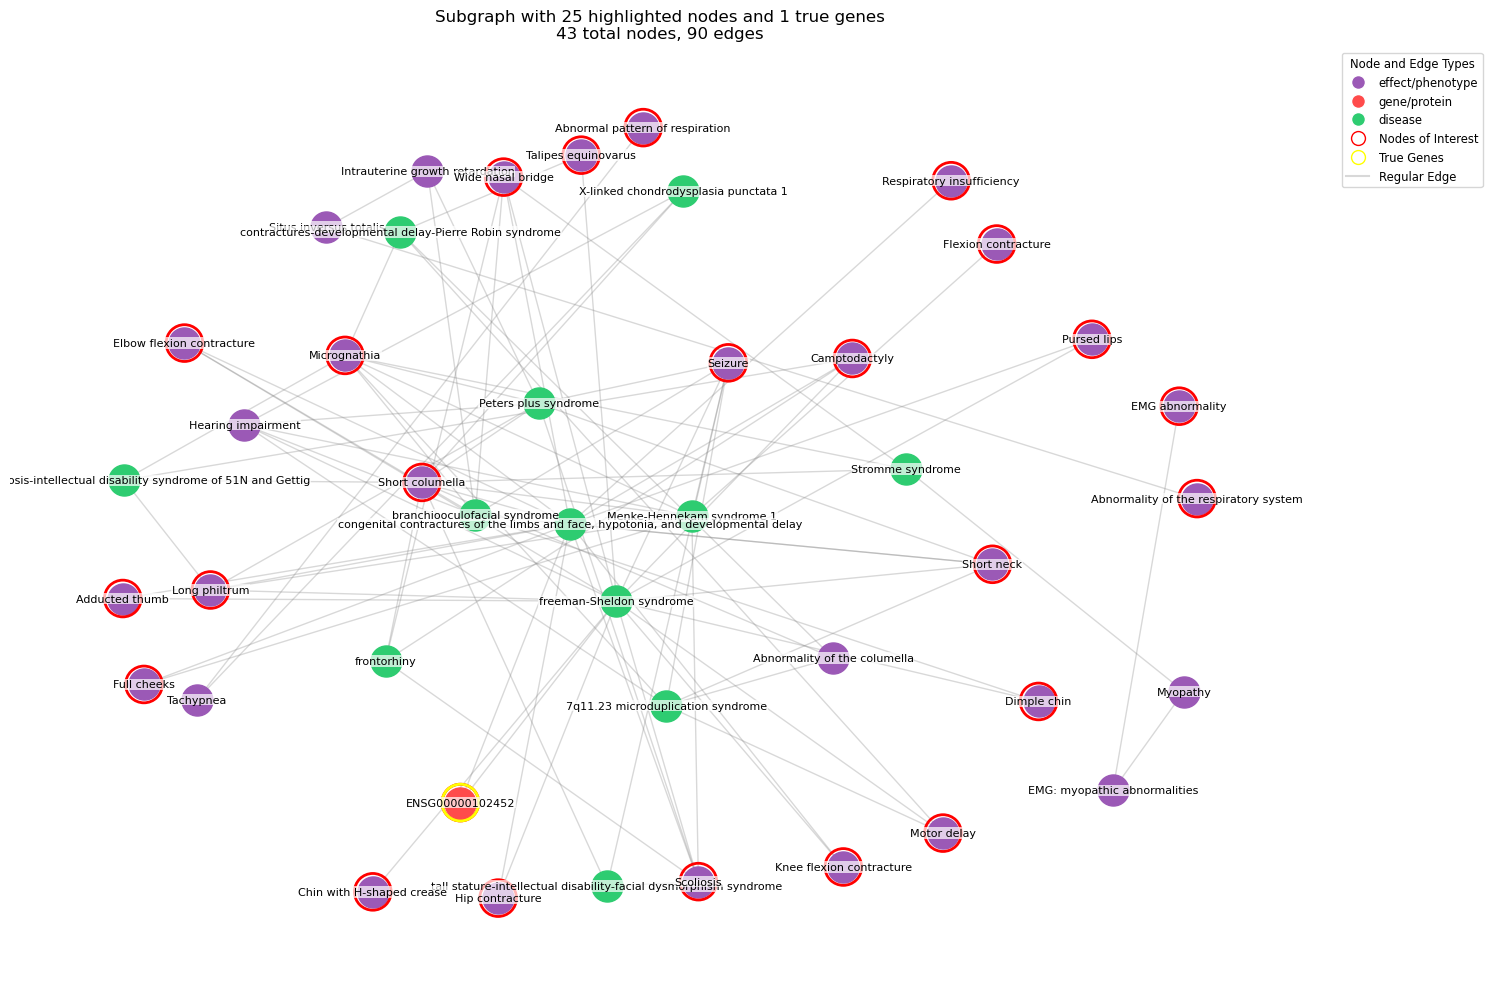

In [19]:
## Plot out the test data
## The grpah shows the connection between the patient's phenotypes, the candidate genes and the true genes of test data

i=1

kg.visualize_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])

In [22]:
## To map the local id to global id
train_nx_subgraph = []
train_pg_subgraph = []

for i in range(len(train_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in train_patients_phenotypes_list[i] + train_all_candidate_genes[i] + train_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in train_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    train_nx_subgraph.append(subgraph)
    train_pg_subgraph.append(pg_graph)

In [26]:
train_pg_subgraph[0].true_gene.ids

AttributeError: 'GlobalStorage' object has no attribute 'true_gene'

In [127]:
print(train_pg_subgraph[0])
print(len(train_pg_subgraph))
## x = 58 nodes, there are 7 types of nodes
## edge_index: 196 connections between nodes
## edge_attr: 15 types of the connections


Data(
  x=[58, 7],
  edge_index=[2, 196],
  edge_attr=[196, 15],
  node_mapping={
    14012=0,
    25375=1,
    1591=2,
    14744=3,
    60332=4,
    1604=5,
    69662=6,
    15322=7,
    51663=8,
    15274=9,
    2448=10,
    5784=11,
    2491=12,
    20953=13,
    10649=14,
    54643=15,
    9967=16,
    3170=17,
    28869=18,
    14016=19,
    19172=20,
    14120=21,
    729=22,
    19674=23,
    12868=24,
    4536=25,
    27869=26,
    20079=27,
    15350=28,
    54520=29,
    14341=30,
    14923=31,
    14042=32,
    12554=33,
    26552=34,
    15567=35,
    51614=36,
    988=37,
    12980=38,
    14231=39,
    395=40,
    14015=41,
    20698=42,
    23595=43,
    14434=44,
    24307=45,
    15726=46,
    14138=47,
    10335=48,
    27771=49,
    15279=50,
    16340=51,
    26446=52,
    14430=53,
    14594=54,
    14013=55,
    19829=56,
    5925=57,
  },
  node_names=[58],
  original_ids=[58],
  node_type_mapping={
    biological_process=0,
    cellular_component=1,
    disease=

In [129]:
val_nx_subgraph = []
val_pg_subgraph = []

for i in range(len(val_patients_phenotypes_list)):

    # Without patients
    subgraph = kg.create_subgraph([str(n) for n in val_patients_phenotypes_list[i]+ val_all_candidate_genes[i]+ val_patients_genes[i]], true_gene_ids = [str(k) for k in val_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    val_nx_subgraph.append(subgraph)
    val_pg_subgraph.append(pg_graph)

In [124]:
test_nx_subgraph = []
test_pg_subgraph = []

for i in range(len(test_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    test_nx_subgraph.append(subgraph)
    test_pg_subgraph.append(pg_graph)

In [16]:
import pytorch_lightning as pl
import torch
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCNEmbeddingModel(pl.LightningModule):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)  # Final node embeddings
        return x

In [17]:
# Initialize model
in_channels = train_pg_subgraph[0].x.size(1)  # Number of input features
hidden_channels = 128  
out_channels = 16   ## should be determined by the later classification task

model = GCNEmbeddingModel(in_channels, hidden_channels, out_channels)

model = model.to(device)

train_node_embeddings = []
val_node_embeddings = []

model.eval()
with torch.no_grad():
    for graph in train_pg_subgraph:
        graph = graph.to(device)
        embeddings = model(graph.x, graph.edge_index)  # Node embeddings
        train_node_embeddings.append(embeddings.cpu())  # Store embeddings

with torch.no_grad():
    for graph in val_pg_subgraph:
        graph = graph.to(device)
        embeddings = model(graph.x, graph.edge_index)  # Node embeddings
        val_node_embeddings.append(embeddings.cpu())  # Store embeddings


NameError: name 'train_pg_subgraph' is not defined

In [1]:
from torch_geometric.nn import global_mean_pool
import torch

train_graph_embeddings = []  # To store graph-level embeddings
val_graph_embeddings = []    # To store validation graph-level embeddings

model.eval()  # Set the model to evaluation mode (no gradient computation)
with torch.no_grad():
    # For training graphs
    for graph in train_pg_subgraph:
        graph = graph.to(device)  # Move graph to the device
        node_embeddings = model(graph.x, graph.edge_index)  # Node embeddings (Shape: num_nodes, 16)

        # Create batch tensor for each graph (all nodes in the graph will have the same batch ID)
        batch = torch.zeros(node_embeddings.size(0), dtype=torch.long).to(device)

        # Aggregate node embeddings into graph-level embeddings using global mean pooling
        graph_embedding = global_mean_pool(node_embeddings, batch)  # Shape: (1, 16)
        
        # Store the graph embedding for training
        train_graph_embeddings.append(graph_embedding.cpu())  # Store on CPU to avoid GPU memory overflow

    # For validation graphs
    for graph in val_pg_subgraph:
        graph = graph.to(device)  # Move graph to the device
        node_embeddings = model(graph.x, graph.edge_index)  # Node embeddings (Shape: num_nodes, 16)

        # Create batch tensor for each graph (all nodes in the graph will have the same batch ID)
        batch = torch.zeros(node_embeddings.size(0), dtype=torch.long).to(device)

        # Aggregate node embeddings into graph-level embeddings using global mean pooling
        graph_embedding = global_mean_pool(node_embeddings, batch)  # Shape: (1, 16)

        # Store the graph embedding for validation
        val_graph_embeddings.append(graph_embedding.cpu())  # Store on CPU to avoid GPU memory overflow

# Convert the list of graph-level embeddings into a tensor
train_graph_embeddings = torch.stack(train_graph_embeddings)  # Shape: (num_train_graphs, 16)
val_graph_embeddings = torch.stack(val_graph_embeddings)      # Shape: (num_val_graphs, 16)

# Now you have graph-level embeddings (one per graph), ready for further processing (e.g., classification)
print(train_graph_embeddings.shape)  
print(val_graph_embeddings.shape)    # Shape: (num_val_graphs, 16)


NameError: name 'model' is not defined

In [165]:
print(len(train_node_embeddings))
print(train_node_embeddings[0].shape)

36224
torch.Size([58, 16])


In [180]:
# Stack all node embeddings (list of tensors) into a single tensor
stacked_train_node_embeddings = torch.cat(train_node_embeddings, dim=0)
print(stacked_train_node_embeddings.shape) 

stacked_val_node_embeddings = torch.cat(val_node_embeddings, dim=0)
print(stacked_val_node_embeddings.shape)



torch.Size([2507764, 16])
torch.Size([438620, 16])


In [ ]:
# import networkx as nx

# # Assuming test_nx_subgraph is a list of graphs
# subgraph = train_nx_subgraph[3]  # First subgraph

# # Check if the graph is directed
# is_directed = subgraph.is_directed()

# # Check if the graph is connected
# # For directed graphs, check strongly connected or weakly connected
# if is_directed:
#     is_connected = nx.is_strongly_connected(subgraph)  # Strongly connected
#     is_weakly_connected = nx.is_weakly_connected(subgraph)  # Weakly connected
#     print(f"Graph is directed: {is_directed}")
#     print(f"Graph is strongly connected: {is_connected}")
#     print(f"Graph is weakly connected: {is_weakly_connected}")
# else:
#     is_connected = nx.is_connected(subgraph)  # Connected (undirected case)
#     print(f"Graph is directed: {is_directed}")
#     print(f"Graph is connected: {is_connected}")

In [ ]:
# # Create the output directory if it doesn't exist
# output_folder = './Graph Outputs'
# os.makedirs(output_folder, exist_ok=True)

# # Combined lists to save
# lists_to_save = {
#     'val_nx_subgraph': val_nx_subgraph,
#     'val_pg_subgraph': val_pg_subgraph,

#     'train_nx_subgraph': train_nx_subgraph,
#     'train_pg_subgraph': train_pg_subgraph,

#     'test_nx_subgraph': test_nx_subgraph,
#     'test_pg_subgraph': test_pg_subgraph,
# }

# # Save each list using pickle
# for list_name, list_data in lists_to_save.items():
#     file_path = os.path.join(output_folder, f'{list_name}.pkl')
#     with open(file_path, 'wb') as file:
#         pickle.dump(list_data, file)
#     print(f'Saved {list_name} to {file_path}')

In [169]:
import torch.nn as nn

## Define the population-level graph model
class PopulationLevelGraph(pl.LightningModule):
    def __init__(self, embedding_dim, latent_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim

        ## map node embedding to lower-dimensional latent space
        self.latent_transform = nn.Sequential(
            nn.Linear(self.embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, self.latent_dim),
            nn.ReLU()
        )
        
        ## define Learnable parameters 
        self.temperature = nn.Parameter(torch.tensor(1.0))  # t
        self.threshold = nn.Parameter(torch.tensor(0.0))    # θ
        
    def compute_population_graph(self, graph_representations):
        """
        Compute the weighted adjacency matrix (A_p) based on input graph representations.
        """
        # Project into latent space
        latent_space = self.latent_transform(graph_representations)
        latent_space =F.normalize(latent_space, p=2, dim=-1)
        # Compute pairwise distances in latent space
        pairwise_distances = torch.cdist(latent_space, latent_space, p=2) ** 2
        
        # Compute adjacency matrix using sigmoid function
        adjacency_matrix = torch.sigmoid(-self.temperature * pairwise_distances + self.threshold)
        return adjacency_matrix

    def compute_node_degree_distribution_loss(self, adjacency_matrix):
        """
        Regularize adjacency matrix using Node Degree Distribution Loss (NDDL).
        """
        # Compute node degrees
        degrees = adjacency_matrix.sum(dim=1)

        # Normalize degrees
        std = degrees.std() + 1e-6  # Add epsilon for numerical stability
        normalized_degrees = (degrees - degrees.mean()) / std

        # Define target Gaussian distribution
        target = torch.distributions.Normal(0.0, 1.0)  # Mean=0, Std=1
        target_probs = target.log_prob(normalized_degrees)

        # Compute KL Divergence
        kl_loss = F.kl_div(normalized_degrees.log_softmax(dim=0), target_probs.softmax(dim=0), reduction="batchmean")
        return kl_loss
            
    def training_step(self, batch):
        """
        Training step for the model.
        """
        graph_representations = batch  # Directly use the input graph representations

        # Compute adjacency matrix
        adjacency_matrix = self.compute_population_graph(graph_representations)

        # Compute NDDL
        nddl_loss = self.compute_node_degree_distribution_loss(adjacency_matrix)

        # Sparsity regularization
        sparsity_loss = adjacency_matrix.sum() * 1e-3

        # Total loss
        total_loss = nddl_loss + sparsity_loss
        self.log("train_loss", total_loss)

        return total_loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        """
        Validation step for the model.
        Computes adjacency matrix and evaluates losses on validation data.
        """
        graph_representations = batch  # Input graph representations

        # Compute adjacency matrix
        adjacency_matrix = self.compute_population_graph(graph_representations)

        # Compute NDDL loss
        nddl_loss = self.compute_node_degree_distribution_loss(adjacency_matrix)

        # Sparsity regularization loss
        sparsity_loss = adjacency_matrix.sum() * 1e-3

        # Total validation loss
        total_loss = nddl_loss + sparsity_loss

        # Log validation losses
        self.log("val_loss", total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_nddl_loss", nddl_loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_sparsity_loss", sparsity_loss, on_step=False, on_epoch=True, prog_bar=False)

        return {"val_loss": total_loss, "adjacency_matrix": adjacency_matrix}

    
    def validation_step(self, batch, batch_idx):
        """
        Validation step for the model.
        Computes adjacency matrix and evaluates losses on validation data.
        """
        graph_representations = batch  # Input graph representations

        # Compute adjacency matrix
        adjacency_matrix = self.compute_population_graph(graph_representations)

        # Compute NDDL loss
        nddl_loss = self.compute_node_degree_distribution_loss(adjacency_matrix)

        # Sparsity regularization loss
        sparsity_loss = adjacency_matrix.sum() * 1e-3

        # Total validation loss
        total_loss = nddl_loss + sparsity_loss

        # Log validation losses
        self.log("val_loss", total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_nddl_loss", nddl_loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_sparsity_loss", sparsity_loss, on_step=False, on_epoch=True, prog_bar=False)

        return {"val_loss": total_loss, "adjacency_matrix": adjacency_matrix}
    
    def configure_optimizers(self):
        """
        Define optimizer for training.
        """
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [183]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(stacked_train_node_embeddings)
val_dataset = TensorDataset(stacked_val_node_embeddings)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [184]:
# Initialize Model
model = PopulationLevelGraph(embedding_dim=16, latent_dim=128)

# Trainer
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True, min_delta=0.001)
trainer = pl.Trainer(max_epochs=50, accelerator="gpu", devices="auto", callbacks=[early_stopping])

# Train Model
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | latent_transform | Sequential | 18.7 K | train
  | other params     | n/a        | 2      | n/a  
--------------------------------------------------------
18.7 K    Trainable params
0         Non-trainable params
18.7 K    Total params
0.075     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kai/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/kai/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.001

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
## Get the adjacency matrix

## set the model to evaluation mode
model.eval
model.to(device)

## get subgraph
num_nodes = 30
sub_node_indices = np.random.choice(len(node_embeddings), num_nodes, replace=False)
sub_node_embeddings = node_embeddings[sub_node_indices]
## compute the adjacency matrix
adjacency_matrix = model.compute_population_graph(sub_node_embeddings)

torch.save(adjacency_matrix, './Output/sub_adjacency_matrix.pt')

In [ ]:
## Visulaize the adjacency matrix
## Load the adjacency matrix
adjacency_matrix = torch.load('./Output/sub_adjacency_matrix.pt').cpu().detach().numpy()

np.savetxt('./Output/sub_adjacency_matrix.csv', adjacency_matrix, delimiter=',')

off_diag = np.triu(adjacency_matrix, k=1)
off_diag = off_diag.flatten()

## Set the threshold
mean_value = np.mean(off_diag)
median_value = np.median(off_diag)
print(f"Mean Value: {mean_value}")
print(f"Median Value: {median_value}")
np.fill_diagonal(adjacency_matrix, 0)

## exclude the meaningless connections
threshold_meaningless = mean_value
adjacency_matrix[adjacency_matrix < threshold_meaningless] = 0

## create graph from adjacency matrix
graph = nx.from_numpy_array(adjacency_matrix)

# Customize node attributes
node_labels = {i: f"Patient {i}" for i in range(graph.number_of_nodes())}
node_colors = ["red" if i < 10 else "green" if i < 20 else "purple" for i in graph.nodes]
node_sizes = [500 if i < 5 else 300 for i in graph.nodes]

# Customize edge attributes based on weights
edges, weights = zip(*nx.get_edge_attributes(graph, "weight").items())
strong_connection_threshold = mean_value *10  # Adjust this threshold for strong connections
edge_colors = ["blue" if w > strong_connection_threshold else "gray" for w in weights]
edge_widths = [2 + 2 * w for w in weights]  # Thickness scales with weight

# Generate a layout for the graph
pos = nx.spring_layout(graph, seed=42)  # Use spring layout for better visualization

# Plot the graph
plt.figure(figsize=(16, 12))
nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, width=edge_widths, alpha=0.6)
nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=10, font_color="black")

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], color="blue", lw=3, label="Strong Connection"),
    plt.Line2D([0], [0], color="gray", lw=1, label="Weak Connection"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Category 1"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="green", markersize=10, label="Category 2"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="purple", markersize=10, label="Category 3"),
]
plt.legend(handles=legend_elements, loc="upper right", fontsize=12)

plt.title("Graph Representation with Strong Connections and No Self-Loops", fontsize=16)
plt.axis("off")  # Hide axis for cleaner visualization
plt.show()
